In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# colab pro 더 빠른 GPU 사용
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 17 07:55:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# colab pro 추가 메모리
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# nltk에서 stopwords 다운로드
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import re
import numpy as np
import pandas as pd
import time
#import pyLDAvis
#import pyLDAvis.gensim_models
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from matplotlib import pyplot as plt

import gensim
import string
from gensim import corpora
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import multiprocessing
num_cores = multiprocessing.cpu_count()

# Change this to where your datasets are located:
os.chdir("/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/training_gold_standards") # 현재 디렉토리 설정. 

## 확인 필요. 문제 없으면 지울 수 있음. ##
# Check versions to ensure that there are no compatability issues:
python_version = !python --version
print("Python Version: ", python_version)
print("Current Directory: ", os.getcwd())
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)

Python Version:  ['Python 3.7.12']
Current Directory:  /content/drive/MyDrive/Aiffel_Hackathon/financial_documents/training_gold_standards
Numpy version:  1.19.5
Pandas version:  1.1.5


## Gold Standard Summary
Gold Summary 파일 중에서 text 부분인 "_1" 파일만 csv 파일에 넣어서 리스트를 만들어주고 "_1" 파일을 읽어와서 

In [ ]:
gs_list = os.listdir("/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/Validation/validation_gold_standards")
len(gs_list)

gs_df = pd.DataFrame(gs_list, columns=['Original_Filename']) 
gs_df['Original_Filename'] = gs_df['Original_Filename'].str.replace('.txt', '') 
gs_df[['Document', 'Middle', 'Section']] = gs_df['Original_Filename'].str.split('_').tolist() 
gs_df.head()

878

,Original_Filename,Document,Middle,Section
0,30777_904922_8,30777,904922,8
1,30777_904925_1,30777,904925,1
2,30778_904961_1,30778,904961,1
3,30778_904959_8,30778,904959,8
4,30779_904980_8,30779,904980,8


In [ ]:
gs_df = gs_df.loc[gs_df['Section'] == "1"]
print(len(gs_df))
gs_df.head()

363


,Original_Filename,Document,Middle,Section
1,30777_904925_1,30777,904925,1
2,30778_904961_1,30778,904961,1
6,30779_904981_1,30779,904981,1
9,30781_905033_1,30781,905033,1
11,30782_905061_1,30782,905061,1


In [ ]:
gs_path = []
for path in gs_list:
  if '_1.txt' in path:
    gs_path.append(path)

print(len(gs_path))
gs_path[:5]

363


['30777_904925_1.txt',
 '30778_904961_1.txt',
 '30779_904981_1.txt',
 '30781_905033_1.txt',
 '30782_905061_1.txt']

In [ ]:
gs_file_path = "/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/Validation/validation_gold_standards/"

doc_lengths = []
for path in gs_path:
  with open(gs_file_path + path, "r", encoding='utf-8') as f:
    temp_str = '' 
    for line in f: 
      line = line.replace('\n', ' ') 
      temp_str += line
      temp_len = len(temp_str.split())
    doc_lengths.append(temp_len)
  
gs_df['Length'] = doc_lengths


[879, 1325, 978, 416, 1303, 2531, 615, 1155, 1455, 1749, 2451, 1834, 848, 1344, 730, 561, 3197, 1372, 488, 977, 448, 962, 1770, 1179, 890, 1606, 895, 752, 1535, 1439, 1465, 2248, 1647, 1245, 1074, 1356, 1225, 1786, 1021, 1136, 1813, 833, 739, 1259, 2042, 1315, 848, 436, 1060, 1468, 646, 1136, 587, 1054, 1083, 500, 522, 765, 413, 487, 2107, 537, 687, 367, 564, 624, 1042, 1420, 913, 1219, 1383, 775, 485, 1235, 1605, 1481, 715, 683, 1231, 762, 555, 1462, 961, 919, 1781, 1572, 634, 1517, 447, 667, 339, 503, 864, 1242, 1166, 891, 1503, 380, 641, 1176, 887, 1649, 812, 709, 617, 738, 1541, 2959, 1941, 716, 808, 766, 1254, 720, 1090, 702, 739, 1390, 682, 1509, 875, 895, 1445, 864, 2242, 1354, 1450, 767, 1073, 780, 1278, 416, 1540, 1629, 1392, 1664, 823, 371, 1355, 1004, 834, 802, 1247, 627, 854, 1245, 441, 866, 937, 673, 590, 608, 1119, 1320, 439, 1836, 1330, 860, 712, 877, 817, 2241, 1242, 534, 1262, 569, 948, 627, 558, 712, 994, 890, 938, 1461, 539, 880, 1196, 755, 1477, 661, 375, 544, 1285,

In [ ]:
print(len(gs_df))
gs_df.head()

363


,Original_Filename,Document,Middle,Section,Length
1,30777_904925_1,30777,904925,1,879
2,30778_904961_1,30778,904961,1,1325
6,30779_904981_1,30779,904981,1,978
9,30781_905033_1,30781,905033,1,416
11,30782_905061_1,30782,905061,1,1303


### Training Sections
Analyze the Training Data Sections - similar to above

In [ ]:
test_list = os.listdir("/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/Validation/validation_sections_2/")
len(test_list)
test_df = pd.DataFrame(test_list, columns=['Original_Filename'])
test_df['Original_Filename'] = test_df['Original_Filename'].str.replace('.txt', '')
test_df[['Document', 'Middle', 'Section']] = test_df['Original_Filename'].str.split('_').tolist()

test_df.head()


372

,Original_Filename,Document,Middle,Section
0,30777_904926_2,30777,904926,2
1,30778_904963_2,30778,904963,2
2,30779_904986_2,30779,904986,2
3,30781_905026_2,30781,905026,2
4,30782_905054_2,30782,905054,2


In [ ]:
test_df = test_df.loc[test_df['Section'] == "2"]
print(len(test_df))
test_df.head()

372


,Original_Filename,Document,Middle,Section
0,30777_904926_2,30777,904926,2
1,30778_904963_2,30778,904963,2
2,30779_904986_2,30779,904986,2
3,30781_905026_2,30781,905026,2
4,30782_905054_2,30782,905054,2


In [ ]:
test_list[1:3]

['30778_904963_2.txt', '30779_904986_2.txt']

In [ ]:
test_file_path = "/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/Validation/validation_sections_2/"

test_doc_lengths = []
for path in test_list:
  with open(test_file_path + path, "r", encoding='utf-8') as f:
    temp_str = '' 
    for line in f: 
      line = line.replace('\n', ' ') 
      temp_str += line
      temp_len = len(temp_str.split())
    test_doc_lengths.append(temp_len)
  
test_df['Length'] = test_doc_lengths


In [ ]:
print(len(test_df))
test_df.head()

372


,Original_Filename,Document,Middle,Section,Length
0,30777_904926_2,30777,904926,2,1517
1,30778_904963_2,30778,904963,2,3684
2,30779_904986_2,30779,904986,2,4015
3,30781_905026_2,30781,905026,2,1639
4,30782_905054_2,30782,905054,2,4107


In [ ]:
test_df = test_df.drop_duplicates(subset=['Document', 'Section'], keep='first')
print(len(test_df))

363


## Text Length Comparisons
Analyze the Text by word count to get some statistics.

count      363.000000
mean      2247.542700
std       1472.616672
min         43.000000
25%       1343.500000
50%       1888.000000
75%       2786.000000
max      13355.000000
Name: Length, dtype: float64

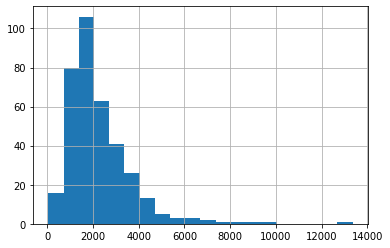

In [ ]:
test_df['Length'].describe()
test_df['Length'].hist(bins=20)

In [ ]:
over4000 = test_df[test_df['Length'] > 4000]
print(len(over4000))
print("ratio: ", len(over4000)/len(test_df['Length'])*100)

32
ratio:  8.81542699724518


In [ ]:
over500 = 500 < test_df['Length']
less4000 = 4000 > test_df['Length']
new_test_df = test_df[over500 & less4000]
len(new_test_df)

326

In [ ]:
test_data = new_test_df.merge(gs_df, how='left', on=['Document'])
print(len(test_data))
test_data.head()

326


,Original_Filename_x,Document,Middle_x,Section_x,Length_x,Original_Filename_y,Middle_y,Section_y,Length_y
0,30777_904926_2,30777,904926,2,1517,30777_904925_1,904925,1,879
1,30778_904963_2,30778,904963,2,3684,30778_904961_1,904961,1,1325
2,30781_905026_2,30781,905026,2,1639,30781_905033_1,905033,1,416
3,30783_905079_2,30783,905079,2,1071,30783_905078_1,905078,1,615
4,30785_905133_2,30785,905133,2,1071,30785_905132_1,905132,1,2531


count     326.000000
mean     1040.978528
std       522.862950
min       172.000000
25%       684.000000
50%       897.500000
75%      1314.000000
max      4187.000000
Name: Length_y, dtype: float64

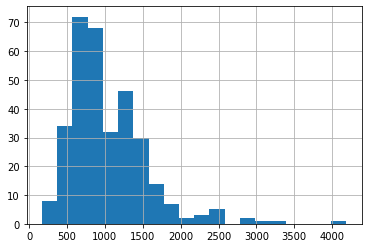

In [ ]:
# gold summary의 길이 확인 
test_data['Length_y'].describe()
test_data['Length_y'].hist(bins=20)

In [ ]:
over200 = test_data['Length_y'] > 200
less1500 = test_data['Length_y'] < 1500
test_data = test_data[over200 & less1500]
len(test_data)
test_data.head()

280

,Original_Filename_x,Document,Middle_x,Section_x,Length_x,Original_Filename_y,Middle_y,Section_y,Length_y
0,30777_904926_2,30777,904926,2,1517,30777_904925_1,904925,1,879
1,30778_904963_2,30778,904963,2,3684,30778_904961_1,904961,1,1325
2,30781_905026_2,30781,905026,2,1639,30781_905033_1,905033,1,416
3,30783_905079_2,30783,905079,2,1071,30783_905078_1,905078,1,615
5,30790_905290_2,30790,905290,2,1622,30790_905289_1,905289,1,1155


### Appending the Data

In [ ]:
test_data.rename(columns={'Original_Filename_y' : 'Gold_Filename',
                            'Section_y' : 'Gold Section',
                            'Length_y' : 'Gold_Summary_Length'}, inplace=True)
test_data.head()

,Original_Filename_x,Document,Middle_x,Section_x,Length_x,Gold_Filename,Middle_y,Gold Section,Gold_Summary_Length
0,30777_904926_2,30777,904926,2,1517,30777_904925_1,904925,1,879
1,30778_904963_2,30778,904963,2,3684,30778_904961_1,904961,1,1325
2,30781_905026_2,30781,905026,2,1639,30781_905033_1,905033,1,416
3,30783_905079_2,30783,905079,2,1071,30783_905078_1,905078,1,615
5,30790_905290_2,30790,905290,2,1622,30790_905289_1,905289,1,1155


In [ ]:
test_data.to_csv("/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/Bo_data/test_file_list.csv")

In [ ]:
test_file_list = [x + str(".txt") for x in test_data['Original_Filename_x']]
len(test_file_list)

280

In [ ]:
test_file_list[1:3]

['30778_904963_2.txt', '30781_905026_2.txt']

In [ ]:
test_file_path = '/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/Validation/validation_sections_2/'

sentence_list = [] 
for i in test_file_list: 
  with open(test_file_path + i, "r", encoding='utf-8') as f: 
    temp_str = '' 
    for line in f: 
      line = line.replace('\n', ' ') 
      temp_str += line 
    sentence_list.append(temp_str)

In [ ]:
len(sentence_list)
sentence_list[10]

280

' CHIEF EXECUTIVE’S STATEMENT FOR STUDENTS DELIVERING 14 THE UNITE GROUP PLC ANNUAL REPORT AND ACCOUNTS 2017 Strategic report I am pleased to report another strong set  of results for the year ended 31 December  2017 . We have maintained our focus on  delivering sustainable growth in recurring  profits and cash flows over the long term,  and on delivering a Home for Success for  all the students who live with us. We do this  by providing great service and operating  brilliant buildings, designed specifically for  students. Our investment discipline ensures  we maintain a robust capital structure and  deliver high-quality earnings. Performance in 2017 resulted in  another year of growth in EPRA earnings,  like-for-like rents and development profits.  EPRA earnings increased by 12% to £70.5  million and now represents one-third of total  shareholder returns. The focus on delivery  of the ongoing earnings performance of  the business is increasingly underpinned  by University backed contr

In [ ]:
test_data['Full_Text'] = sentence_list
test_data.head()

,Original_Filename_x,Document,Middle_x,Section_x,Length_x,Gold_Filename,Middle_y,Gold Section,Gold_Summary_Length,Full_Text
0,30777_904926_2,30777,904926,2,1517,30777_904925_1,904925,1,879,25695 19 March 2018 3:29 PM Proof 7 02 ...
1,30778_904963_2,30778,904963,2,3684,30778_904961_1,904961,1,1325,10 Staffline Group plc Annual Report 2017 Chi...
2,30781_905026_2,30781,905026,2,1639,30781_905033_1,905033,1,416,Results Corero revenue for the year ended 31 ...
3,30783_905079_2,30783,905079,2,1071,30783_905078_1,905078,1,615,STRATEGIC REPORT CHIEF EXECUTIVE’S STATEMENT ...
5,30790_905290_2,30790,905290,2,1622,30790_905289_1,905289,1,1155,2017 has been a year of significant change f...


In [ ]:
summary_file_list = [x + str(".txt") for x in test_data['Gold_Filename']]
print(len(summary_file_list))

280


In [ ]:
summary_file_path = '/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/Validation/validation_gold_standards/'

summary_list = [] 
for i in summary_file_list: 
  with open(summary_file_path + i, "r", encoding='utf-8') as f: 
    temp_str = '' 
    for line in f: 
      line = line.replace('\n', ' ') 
      temp_str += line 
    summary_list.append(temp_str)

In [ ]:
print(len(summary_list))
summary_list[10]

280


' CHAIRMAN’S STATEMENT OUR BRAND STRENGTH OF 12 THE UNITE GROUP PLC ANNUAL REPORT AND ACCOUNTS 2017 Strategic report In 2017 , the business continued the  positive performance of recent years.  Building on the strength of our brand  and our reputation with customers  and Universities, we entered our first  on-campus University partnership with  Aston University and secured two further  development-led University partnerships  with Oxford Brookes University and in  London with planning support from  King’s College, London.  Financial performance has again  been strong, with a total accounting  return of 14% and growth in EPRA earnings,  up 12% to £70.5 million. Profit before tax  was £229.4 million, which includes property  revaluations and disposal profits of £169.2  million (2016: £201.4 million and £136.3  million respectively). As a result of this  performance, we are declaring a final  dividend of 15.4p to deliver a total dividend  of 22.7p for the full year, an increase of 26%  ye

In [ ]:
test_data['Summary_Text'] = summary_list

In [ ]:
test_data.set_index(['Original_Filename_x', 'Gold_Filename'], inplace=True)
test_data2 = test_data[['Document', 'Full_Text', 'Summary_Text']]
test_data2.head()

,,Document,Full_Text,Summary_Text
Original_Filename_x,Gold_Filename,,,
30777_904926_2,30777_904925_1,30777,25695 19 March 2018 3:29 PM Proof 7 02 ...,25695 19 March 2018 3:29 PM Proof 7 A. ...
30778_904963_2,30778_904961_1,30778,10 Staffline Group plc Annual Report 2017 Chi...,6 Staffline Group plc Annual Report 2017 A ye...
30781_905026_2,30781_905033_1,30781,Results Corero revenue for the year ended 31 ...,Corero Network Security plc Annual Report & A...
30783_905079_2,30783_905078_1,30783,STRATEGIC REPORT CHIEF EXECUTIVE’S STATEMENT ...,Summary FY17 was a landmark year in Alpha’s h...
30790_905290_2,30790_905289_1,30790,2017 has been a year of significant change f...,Sir Richard Lapthorne Chairman 2017 has been ...


In [ ]:
test_data.to_csv("/content/drive/My Drive/Aiffel_Hackathon/financial_documents/Bo_data/Test/test_data_long.csv")

In [ ]:
test_data2.to_csv("/content/drive/My Drive/Aiffel_Hackathon/financial_documents/Bo_data/Test/test_data_short.csv")

## 전처리

In [ ]:
test_file_path = "/content/drive/My Drive/Aiffel_Hackathon/financial_documents/Bo_data/Test/test_data_short.csv"

test_data2 = pd.read_csv(test_file_path)
test_data2.head()

,Original_Filename_x,Gold_Filename,Document,Full_Text,Summary_Text
0,30777_904926_2,30777_904925_1,30777,25695 19 March 2018 3:29 PM Proof 7 02 ...,25695 19 March 2018 3:29 PM Proof 7 A. ...
1,30778_904963_2,30778_904961_1,30778,10 Staffline Group plc Annual Report 2017 Chi...,6 Staffline Group plc Annual Report 2017 A ye...
2,30781_905026_2,30781_905033_1,30781,Results Corero revenue for the year ended 31 ...,Corero Network Security plc Annual Report & A...
3,30783_905079_2,30783_905078_1,30783,STRATEGIC REPORT CHIEF EXECUTIVE’S STATEMENT ...,Summary FY17 was a landmark year in Alpha’s h...
4,30790_905290_2,30790_905289_1,30790,2017 has been a year of significant change f...,Sir Richard Lapthorne Chairman 2017 has been ...


In [ ]:
sample1 = test_data2["Full_Text"][149]
sample2 = test_data2["Summary_Text"][149]


In [ ]:
def preprocessing(sentence): 
  sentence = sentence.lower()
  sentence = re.sub("[$]", "dollar ", sentence)
  sentence = re.sub("[£]", "pound ", sentence)
  sentence = re.sub("[%]", " percent", sentence)
  sentence = re.sub(r"[^a-zA-Z0-9?!.,’-]", ' ', sentence)
  sentence = re.sub(r"([?!])", r" \1 ", sentence)
  sentence = re.sub(r'([a-z])(?=[.,])', r'\1 ', sentence)
  sentence = re.sub(r"\s+", " ", sentence)
  return sentence

In [ ]:
# full text testing
pro_sample1 = preprocessing(sample1)
pro_sample1

' 12 barratt developments plc annual report and accounts 2017 strategic report governance financial statements other information chief executive’s statement pound 765. 1m profit before tax 2016 pound 682.3m 29.8 percent return on capital employed 2016 27.1 percent our businesses our improved financial results have been driven by a strong and disciplined operational performance in both our housebuilding and commercial developments businesses . housebuilding housebuilding results the business performed well throughout the financial year and delivered against both its financial and operational targets . market conditions remain supportive , with attractive mortgage financing and the support of help to buy driving strong consumer demand . we are the uk’s largest housebuilder with total completions at 17,395 units including jv’s 2016 17,319 . private completions increased by 0.8 percent to 13,303 2016 13,198 , affordable completions were 3,342 2016 2,707 , and jv completions in which the gr

In [ ]:
# full text 원본. 위에 전처리 된 것과 비교. 
test_data["Full_Text"][149]

' 12       Barratt Developments PLC – Annual Report and Accounts 2017 Strategic Report Governance Financial Statements Other Information Chief Executive’s statement £765. 1m Profit before tax   (2016: £682.3m) 29.8% Return on capital employed   (2016: 27.1%) Our businesses Our improved financial results have been  driven by a strong and disciplined operational  performance in both our housebuilding and  commercial developments businesses.  Housebuilding Housebuilding results The business performed well throughout  the financial year and delivered against  both its financial and operational targets.  Market conditions remain supportive,  with attractive mortgage financing and  the support of Help to Buy driving strong  consumer demand. We are the UK’s largest housebuilder with  total completions at 17,395 units including JV’s  (2016: 17,319). Private completions increased  by 0.8% to 13,303 (2016: 13,198), affordable  completions were 3,342 (2016: 2,707), and  JV completions in which th

In [ ]:
# gold summary testing 
pro_sample2 = preprocessing(sample2)
pro_sample2

' 8 barratt developments plc annual report and accounts 2017 strategic report governance financial statements other information chairman’s statement this has been another excellent year for the group across all key operational and financial performance metrics . john allan chairman 41.7p total dividend per share 2016 30.7p pound 1.4bn capital return plan over four years ending november 2018 based on consensus earnings this has been another excellent year for the group across all key operational and financial performance metrics . we achieved record profits , completion volumes were at their highest level for nine years and we remain industry leading in terms of quality and customer service . we have delivered our fy17 financial targets of 20 percent gross margin and 25 percent roce , and we are committed to further progress . improving our profit margin remains a priority for the group and we have a number of initiatives underway to further increase efficiency , reduce costs and simpli

In [ ]:
unclean_full_text = list(test_data2['Full_Text'])
clean_full_text =[]
for item in unclean_full_text: 
  sentences = preprocessing(item)
  clean_full_text.append(sentences)

In [ ]:
unclean_sum_text = list(test_data2['Summary_Text'])
clean_summary_text =[]
for item in unclean_sum_text: 
  sentences = preprocessing(item)
  clean_summary_text.append(sentences)

In [ ]:
# Replace the columns with the clean data
test_data2["Full_Text"] = clean_full_text
test_data2["Summary_Text"] = clean_summary_text

In [ ]:
test_data2.to_csv("/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/Bo_data/Test/Test_Data_Clean.csv")